## Import libraries


In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from shapely.geometry import Point, box
from tqdm.auto import tqdm

data_dir = "/beegfs/halder/GITHUB/RESEARCH/WBCrop/data/"

## Read the data


In [2]:
wbcrop_fields = gpd.read_file(os.path.join(data_dir, "processed", "wbcrop_fields.gpkg"))
print(wbcrop_fields.shape)
wbcrop_fields.head()

(42476, 13)


,id,area,crop,district,state,sowing,harvest,collection_date,season,pheno_stage,latitude,longitude,geometry
0,0,548.133850,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.517974,89.779633,"POLYGON ((777013.308 2936062.776, 777011.355 2..."
1,1,321.617126,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.517782,89.780011,"POLYGON ((777049.716 2936043.698, 777047.763 2..."
2,2,1198.844910,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.515884,89.773070,"POLYGON ((776315.379 2935824.604, 776314.403 2..."
3,3,311.393738,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.515719,89.773027,"POLYGON ((776354.032 2935795.51, 776353.446 29..."
4,4,394.783020,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.517747,89.780148,"POLYGON ((777063.665 2936041.147, 777061.907 2..."


## Data cleaning


### Find the out the outlier fields


In [3]:
# Calculate IQR bounds
Q1 = wbcrop_fields["area"].quantile(0.25)
Q3 = wbcrop_fields["area"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter
wbcrop_fields_filtered = wbcrop_fields[(wbcrop_fields["area"] <= upper_bound)]
wbcrop_fields_outlier = wbcrop_fields[(wbcrop_fields["area"] > upper_bound)]
print(f"Before: {wbcrop_fields.shape[0]} | After: {wbcrop_fields_filtered.shape[0]}")

Before: 42476 | After: 38254


### Update the geometry to square box


In [4]:
# Create GeoDataFrame from lat/lon
wbcrop_fields_outlier_points = gpd.GeoDataFrame(
    wbcrop_fields_outlier.copy(),
    geometry=gpd.points_from_xy(
        wbcrop_fields_outlier["longitude"], wbcrop_fields_outlier["latitude"]
    ),
    crs="EPSG:4326",
)

# Project to metric CRS
wbcrop_fields_outlier_points = wbcrop_fields_outlier_points.to_crs(wbcrop_fields.crs)


def create_square_from_point(point_geom, side_length=10):
    """
    Create square centered at point.
    side_length in meters.
    """
    x, y = point_geom.x, point_geom.y
    half = side_length / 2
    return box(x - half, y - half, x + half, y + half)


# Replace geometry with square
wbcrop_fields_outlier_points["geometry"] = wbcrop_fields_outlier_points.geometry.apply(
    lambda pt: create_square_from_point(pt, side_length=30)
)

print(wbcrop_fields_outlier_points.shape)
wbcrop_fields_outlier_points.head()

(4222, 13)


,id,area,crop,district,state,sowing,harvest,collection_date,season,pheno_stage,latitude,longitude,geometry
27,29,9736.022949,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.692587,89.072894,"POLYGON ((706260.856 2954048.588, 706260.856 2..."
67,71,7920.989990,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.686121,89.065917,"POLYGON ((705578.152 2953320.871, 705578.152 2..."
97,102,4531.478882,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.593440,89.183183,"POLYGON ((717425.153 2943246.051, 717425.153 2..."
125,131,6424.484253,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.621852,89.186640,"POLYGON ((717715.677 2946400.099, 717715.677 2..."
127,133,4660.034180,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.621108,89.186333,"POLYGON ((717686.53 2946317.145, 717686.53 294..."


### Merge both the dataframes


In [5]:
wbcrop_fields_filtered["is_transformed"] = False
wbcrop_fields_outlier_points["is_transformed"] = True

final_gdf = pd.concat(
    (wbcrop_fields_filtered, wbcrop_fields_outlier_points), axis=0, ignore_index=True
)
final_gdf.sort_values(by=["id"], inplace=True)
final_gdf.reset_index(drop=True, inplace=True)
final_gdf["area_ha"] = final_gdf.geometry.area / 10000

print(final_gdf.shape)
final_gdf.head()

(42476, 15)


/home/halder/miniforge3/envs/geo/lib/python3.12/site-packages/geopandas/geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,id,area,crop,district,state,sowing,harvest,collection_date,season,pheno_stage,latitude,longitude,geometry,is_transformed,area_ha
0,0,548.133850,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.517974,89.779633,"POLYGON ((777013.308 2936062.776, 777011.355 2...",False,0.054857
1,1,321.617126,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.517782,89.780011,"POLYGON ((777049.716 2936043.698, 777047.763 2...",False,0.032230
2,2,1198.844910,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.515884,89.773070,"POLYGON ((776315.379 2935824.604, 776314.403 2...",False,0.119556
3,3,311.393738,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.515719,89.773027,"POLYGON ((776354.032 2935795.51, 776353.446 29...",False,0.031073
4,4,394.783020,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.517747,89.780148,"POLYGON ((777063.665 2936041.147, 777061.907 2...",False,0.039474


### Save the final dataframe


In [6]:
col_order = [
    "id",
    "crop",
    "district",
    "state",
    "sowing",
    "harvest",
    "collection_date",
    "season",
    "pheno_stage",
    "latitude",
    "longitude",
    "area_ha",
    "is_transformed",
    "geometry",
]
final_gdf = final_gdf[col_order]

# Save the data
final_gdf.to_file(os.path.join(data_dir, "processed", "wbcrop_fields_cleaned.gpkg"))

print(final_gdf.shape)
final_gdf.head()

(42476, 14)


,id,crop,district,state,sowing,harvest,collection_date,season,pheno_stage,latitude,longitude,area_ha,is_transformed,geometry
0,0,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.517974,89.779633,0.054857,False,"POLYGON ((777013.308 2936062.776, 777011.355 2..."
1,1,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.517782,89.780011,0.032230,False,"POLYGON ((777049.716 2936043.698, 777047.763 2..."
2,2,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.515884,89.773070,0.119556,False,"POLYGON ((776315.379 2935824.604, 776314.403 2..."
3,3,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.515719,89.773027,0.031073,False,"POLYGON ((776354.032 2935795.51, 776353.446 29..."
4,4,aman_rice,alipurduar,west_bengal,jul_2023,nov_2023,2023-10-26,kharif,grain_filling,26.517747,89.780148,0.039474,False,"POLYGON ((777063.665 2936041.147, 777061.907 2..."


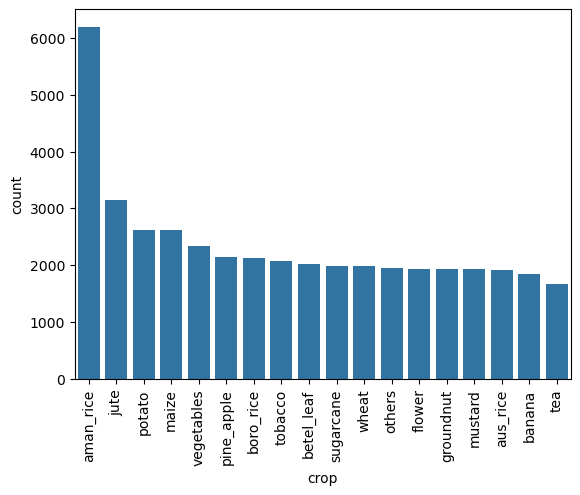

In [9]:
sns.barplot(final_gdf["crop"].value_counts())
plt.xticks(rotation=90)
plt.show()